In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [4]:
L = 5  # Length of the rod
T = 3  # Total time
alpha = 1  # Thermal diffusivity

# Discretization
dx = 0.5
dt = 0.1
Nx = int(L/dx) + 1  # Number of spatial points
Nt = int(T/dt) + 1  # Number of time steps
x = np.linspace(0, L, Nx)  # Space grid
t = np.linspace(0, T, Nt)  # Time grid
print(dx**2 / (2 * alpha))
# Stability condition
print(f"Stability condition (dt <= dx^2 / (2 * alpha)): {dt <= dx**2 / (2 * alpha)}")

# Initial condition
u0 = np.sin(np.pi * x / L)

# Boundary conditions
u_left = 0
u_right = 0

0.125
Stability condition (dt <= dx^2 / (2 * alpha)): True


In [5]:
def solve_heat(f_xt):
  u = np.zeros((Nt, Nx))
  u[0, :] = u0
  u[1, :] = u0

  # Time-stepping loop
  for n in range(0, Nt - 1):
      for i in range(1, Nx - 1):
          u[n + 1, i] = u[n, i] + alpha * dt / dx**2 * (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1]) + dt * f_xt[n,i]
      # Apply boundary conditions
      u[n + 1, 0] = u_left
      u[n + 1, -1] = u_right

  return u

X_xt = np.array([[ti, xi] for ti in t for xi in x])
kernel_xt = 1.0 * RBF(length_scale=1.0)
gpr_xt = GaussianProcessRegressor(kernel=kernel_xt, random_state=42)
f_xt_samples = gpr_xt.sample_y(X_xt, n_samples=10).reshape(Nt, Nx, 10)

In [6]:
#kernel model definition
def Kt(X, Y, col, K):
    l = K.get_params()['length_scale']
    coeff = - (1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T)
    return coeff * K(X, Y)

def Ktt(X, Y, col, K):
    l = K.get_params()['length_scale']
    coeff = (1/l**2) * ((1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T) ** 2 -1)
    return coeff * K(X,Y)


class KernelModel(BaseEstimator, RegressorMixin):
    def __init__(self, nugget=1e-7, length_scale=1, partial_derivative_order=0, partial_derivative_column=0):
        self.length_scale = length_scale
        self.nugget = nugget
        self.partial_derivative_order = partial_derivative_order
        self.partial_derivative_column = partial_derivative_column
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.K = RBF(length_scale=self.length_scale)
        UXX = self.K(self.X_, self.X_)
        UXX_nugget = (UXX + self.nugget ** 2 * np.eye(self.X_.shape[0]))
        self.UXX_inv_y = np.linalg.solve(UXX_nugget, self.y_)
        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)

        if(self.partial_derivative_order == 0):
            UxX = self.K(X, self.X_)

        elif(self.partial_derivative_order == 1):
            UxX = Kt(X, self.X_, self.partial_derivative_column, self.K)

        elif(self.partial_derivative_order == 2):
            UxX = Ktt(X, self.X_, self.partial_derivative_column, self.K)
        return UxX @ self.UXX_inv_y

    def set_params(self, **params):
        if not params:
            return self

        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)

        return self

In [7]:
training_data = []
T,X = np.meshgrid(t, x, indexing='ij')
grid_points = np.c_[T.ravel(), X.ravel()]

np.random.seed(42)

for i in range(10):
    u = solve_heat(f_xt_samples[:, :, i])  # Solution for f(x, t)
    u = u.reshape(-1,1)
    u_std = np.std(u)
    noise = np.random.normal(0, 0.05 * u_std, Nt*Nx)
    u_perturbed = u + noise.reshape(-1,1)

    training_data.append(np.column_stack((grid_points, u_perturbed, u)))


# data [x,t,u_perb(x,t),u(x,t)]
for data in training_data:
  k = data



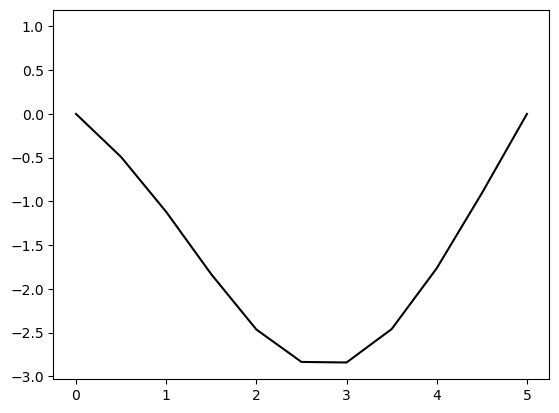

In [8]:
import matplotlib.animation as animation
def create_animation():
    u = solve_heat(f_xt_samples[:, :, 0])  # Solution for f(x, t)
    # u = solve_heat(np.zeros((Nt,Nx)))  # Solution for f(x, t)
    fig = plt.figure()
    plts = []             # get ready to populate this list the Line artists to be plotted
    # plt.hold("off")
    for ti in range(0,Nt):
        p, = plt.plot(x, u[ti,:], 'k')   # this is how you'd plot a single line...
        plts.append( [p] )           # ... but save the line artist for the animation
    ani = animation.ArtistAnimation(fig, plts, interval=50, repeat_delay=3000)   # run the animation
    ani.save('heat.mp4')    # optionally save it to a file

    plt.show()

# create_animation()

0 {'length_scale': 1.22}
1 {'length_scale': 1.08}
2 {'length_scale': 1.1300000000000001}
3 {'length_scale': 1.16}
4 {'length_scale': 1.32}
5 {'length_scale': 1.32}
6 {'length_scale': 1.41}
7 {'length_scale': 0.22}
8 {'length_scale': 1.08}
9 {'length_scale': 1.32}
-4.9608182858638906e-05
{'length_scale': 1.32}


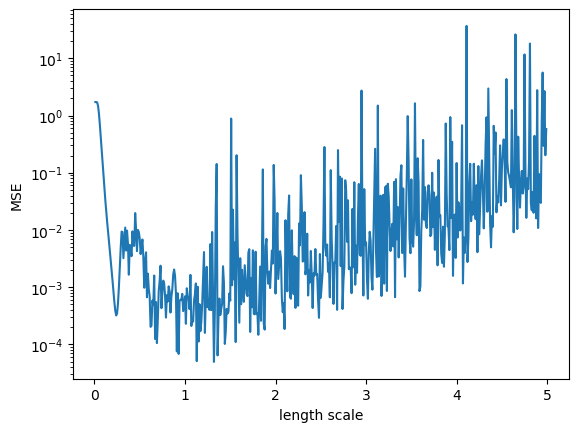

In [72]:
S_array = []
best_params = []
cv_results = []
l_range = np.arange(0.01, 3, 0.01)
eta = 5e-8

i = 0
for data in training_data:
    grid_points = data[:,0:2]
    u_sample = data[:, 3]

    cv = ShuffleSplit(n_splits=10, random_state=0)
    grid_search = GridSearchCV(estimator=KernelModel(eta, 1),
                               param_grid={'length_scale': l_range},
                               cv=cv,
                               scoring='neg_mean_squared_error')

    # Fit the GridSearchCV
    grid_search.fit(grid_points, u_sample)
    km = grid_search.best_estimator_
    s0 = grid_points
    s1 = km.set_params(partial_derivative_order=1,partial_derivative_column=0).predict(grid_points)
    s2 = km.set_params(partial_derivative_order=2,partial_derivative_column=1).predict(grid_points)
    Si = np.column_stack((s0, s1, s2))
    S_array.append(Si)
    best_params.append(grid_search.best_params_)
    cv_results.append(grid_search.cv_results_)
    print(i, grid_search.best_params_)
    i += 1

S = np.vstack(S_array)

{'km__length_scale': 12.01} -0.12665758149162168


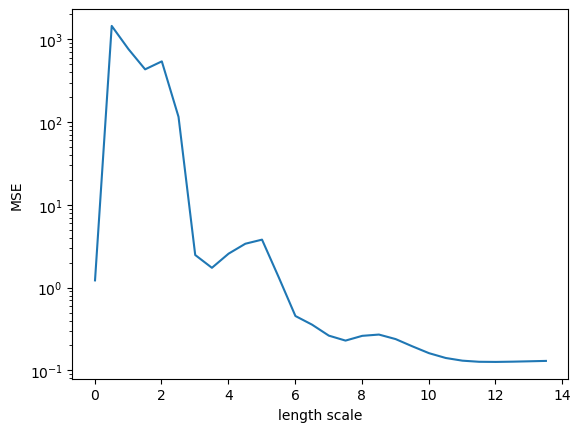

In [100]:
P_l_range = np.arange(0.01, 14, 0.5)
P_eta = 1e-6

y_list = []
for i in range(10):
  k = f_xt_samples[:,:,i].reshape(-1,1)
  y_list.append(k)

y = np.vstack(y_list)
y = y.reshape(y.shape[0],)
X = S

i = Nx*Nt
X_test = S[0:i,:]
y_test = y[0:i]
# y = forcing_terms[0,::31]
# X = S[:30,:]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('km', KernelModel(P_eta, 1))
])

cv = ShuffleSplit(n_splits=10, random_state=0)
grid_search = GridSearchCV(pipeline,
                            param_grid={'km__length_scale': P_l_range},
                            cv=cv,
                            scoring='neg_mean_squared_error')

# Fit the GridSearchCV
grid_search.fit(X, y)
km = grid_search.best_estimator_
P_star = km.predict(X_test)


df = pd.DataFrame(grid_search.cv_results_)
plt.figure()
plt.semilogy(P_l_range, -df['mean_test_score'])
plt.xlabel('length scale')
plt.ylabel('MSE')
print(grid_search.best_params_, grid_search.best_score_)

In [101]:
mean_squared_error(P_star,y_test)

0.05559767108498722

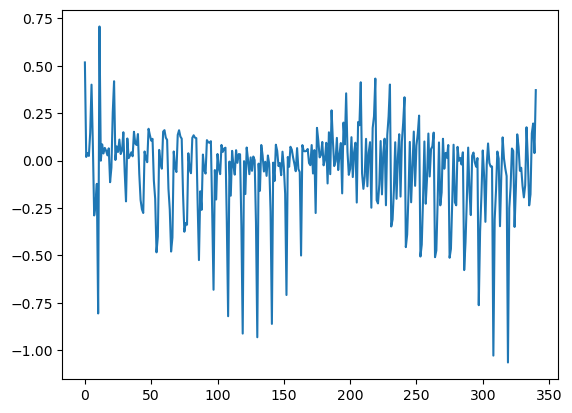

In [102]:
plt.plot(P_star-y_test)